# Setup

In [1]:
import tensorflow as tf
SEED = 126

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()
    
    
tf.random.set_seed(SEED)

Not connected to a TPU runtime. Using CPU/GPU strategy


# Data loader

In [2]:
!rm -r cameroon_ultrasound_images/

rm: cannot remove 'cameroon_ultrasound_images/': No such file or directory


In [3]:
import pandas as pd
import os
import shutil

data_path = '../input/cameroon-ultrasound/data'
train = pd.read_csv(data_path+'/Train.csv')
test = pd.read_csv(data_path+'/Test.csv')


os.mkdir('cameroon_ultrasound_images')
os.mkdir('cameroon_ultrasound_images/train')
os.mkdir('cameroon_ultrasound_images/train/normal')
os.mkdir('cameroon_ultrasound_images/train/failure')


data_path = '../input/cameroon-ultrasound/data/images/'

#train path
dest_path = './cameroon_ultrasound_images/train/'
for elm in train.values:
    if elm[1]==0:
        shutil.copy(data_path+elm[0]+'.jpg', dest_path+'failure/'+elm[0]+'.jpg')
    elif elm[1]==1:
        shutil.copy(data_path+elm[0]+'.jpg', dest_path+'normal/'+elm[0]+'.jpg')

#test path
os.mkdir('cameroon_ultrasound_images/test')
dest_path = './cameroon_ultrasound_images/test/'
for elm in test.values:
    os.mkdir(dest_path+elm[0])
    shutil.copy(data_path+elm[0]+'.jpg', dest_path+elm[0]+'/'+elm[0]+'.jpg')

In [4]:
IMG_SIZE = 600
size = (800, 1000)
NUM_CLASSES = 2

#train
data_dir = 'cameroon_ultrasound_images/train/'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=SEED,
    image_size=size)

#dev
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    label_mode="categorical",
    seed=SEED,
    image_size=size)

#test
data_dir = 'cameroon_ultrasound_images/test/'
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  image_size=size)

Found 100 files belonging to 2 classes.
Using 80 files for training.
Found 100 files belonging to 2 classes.
Using 20 files for validation.
Found 34 files belonging to 34 classes.


# Display some exemples

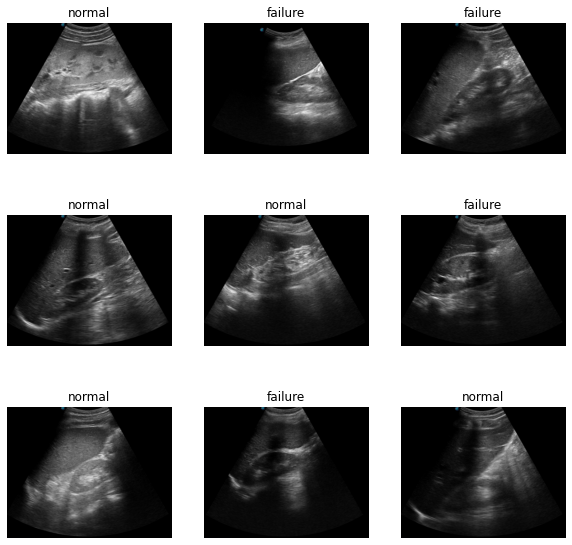

In [5]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i][1])])
        plt.axis("off")
    break

# Train dataset augmentation

In [6]:
from tensorflow.keras import layers
batch_size = 8

train_ds = train_ds.unbatch()

#The augmented dataset are horizontal flips of the original images
aug_ds = train_ds.map(
  lambda x, y: (tf.image.flip_left_right(x), y))

train_ds = train_ds.concatenate(aug_ds)
train_ds = train_ds.shuffle(1000, seed=SEED)
train_ds = train_ds.batch(batch_size)

# Transfer learning with EfficientNet

In [7]:
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB7

shape = (800, 1000, 3)

def build_model(num_classes):
    inputs = layers.Input(shape=shape)
    model = EfficientNetB7(include_top=False, input_tensor=inputs, weights="imagenet", input_shape=shape)

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.3
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", "AUC"]
    )
    return model

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

258080768/258076736 [==============================] - 2s 0us/step
Epoch 1/15
learning rate:0.004999999888241291
20/20 [==============================] - 54s 1s/step - loss: 1.3159 - accuracy: 0.5839 - auc: 0.6191 - val_loss: 0.5138 - val_accuracy: 0.8500 - val_auc: 0.9138
Epoch 2/15
learning rate:0.004524186719208956
20/20 [==============================] - 24s 989ms/step - loss: 1.2818 - accuracy: 0.6532 - auc: 0.7680 - val_loss: 0.5475 - val_accuracy: 0.7500 - val_auc: 0.8625
Epoch 3/15
learning rate:0.004093653056770563
20/20 [==============================] - 24s 996ms/step - loss: 0.4532 - accuracy: 0.8804 - auc: 0.9318 - val_loss: 0.4089 - val_accuracy: 0.7500 - val_auc: 0.9350
Epoch 4/15
learning rate:0.0037040903698652983
20/20 [==============================] - 24s 995ms/step - loss: 0.6979 - accuracy: 0.7654 - auc: 0.8792 - val_loss: 0.4326 - val_accuracy: 0.7500 - val_auc: 0.9025
Epoch 5/15
learning rate:0.00335159944370389
20/20 [==============================] - 23s 991ms

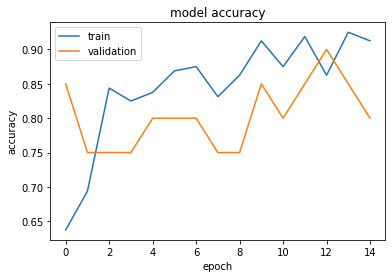

In [8]:
#learning rate scheduler
def scheduler(epoch, lr):
    print(f'learning rate:{lr}')
    return lr * tf.math.exp(-0.1)

with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES)

epochs = 15
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[callback], verbose=1)
plot_hist(hist)

# Prediction

In [9]:
class_names = test_ds.class_names

test_ds = test_ds.unbatch()

predictions = []
ids = []
for image, label in test_ds:
    image = tf.expand_dims(image, 0)
    prediction = model.predict(image)[0]
    predictions.append(prediction[1])
    ids.append(class_names[label])

# Submission

In [10]:
test['img_IDs'] = ids
test['target'] = predictions
test.to_csv("./submission_5.csv", index=False)